In [1]:
using Distributions
using PyCall
using PyPlot
using DelimitedFiles
using LinearAlgebra
using Random
using SparseArrays
using JLD

include("src_spiking_balanced/param.jl");
include("src_spiking_balanced/fun.jl");

# 1. Initial network: strongly and randomly connected excitatory-inhibitory neurons operating in the balanced regime

### Generate recurrent connections of the balanced network.

* Synaptic weights follow the scaling rule: $w_{ij} \sim \frac{1}{\sqrt{K}}$ where $K$ is the average number of connections each neuron receives.

* Each neuron receives constant external input that follows the scaling rule: $m \sim \sqrt{K}.$

* These initial connections of the balanced network will remain static throughout network training.

In [2]:
# Generate the (static) recurrent connections of a balanced network.
include("src_spiking_balanced/genWeights.jl");
w0Index, w0Weights, nc0 = genWeights(p);

### Simulate the activity of balanced network. 

In [3]:
# Simulate the neural activity of the balanced network
include("src_spiking_balanced/lifnet_sim.jl")
times, ns0, _, synExc, synInh = lifnet_sim(p, w0Index, w0Weights, nc0);


mean excitatory firing rate: 6.5588 Hz
mean inhibitory firing rate: 11.9636 Hz


Show strong recurrent excitatory and inhibitory synaptic inputs to neurons balancing each other.

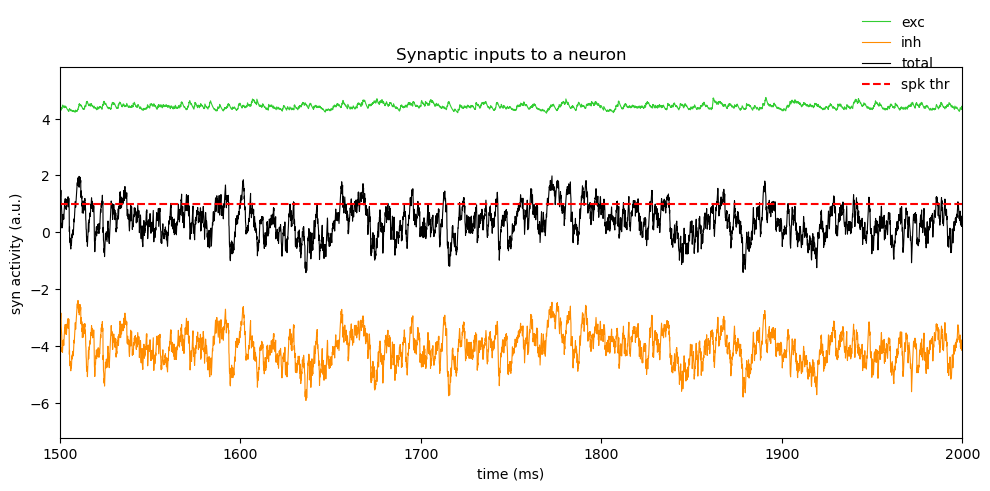

In [4]:
# Plot the synaptic inputs to a neuron
timev = collect(p.dt:p.dt:p.train_time)
figure(figsize=(10,5))
ci = 1
synNet = synExc[ci,:] .+ synInh[ci,:]
title("Synaptic inputs to a neuron")
plot(timev, synExc[ci,:], lw=0.8, c="limegreen", label="exc")
plot(timev, synInh[ci,:], lw=0.8, c="darkorange", label="inh")
plot(timev, synNet, lw=0.8, c="k", label="total")
axhline(1, color="r", linestyle="--", lw=1.5, label="spk thr")
xlim([1500,2000])
xlabel("time (ms)")
ylabel("syn activity (a.u.)")
legend(bbox_to_anchor=[1.0, 0.9], frameon=false)
tight_layout()
PyPlot.display_figs()

Show the spike times of neurons

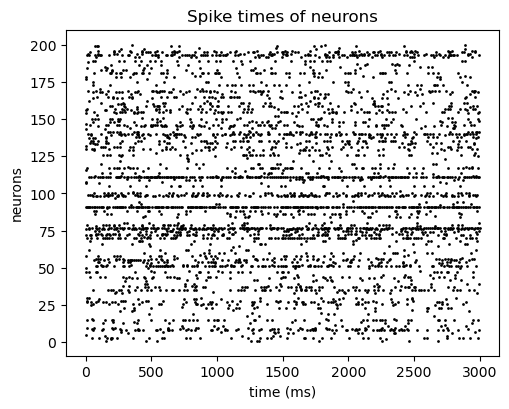

In [5]:
# Show spike times of a population of neurons
figure(figsize=(5,4))
title("Spike times of neurons")
for i = 1:200
    plot(times[i][1:ns0[i]], i*ones(ns0[i]), marker=".", ms=4, mec="None", c="k", linestyle="")
end
tight_layout()
xlabel("time (ms)")
ylabel("neurons")
PyPlot.display_figs()

# 2. Set up to train a subset of neurons to generate target activity patterns

### (a) Target activity patterns: ALM neurons firing rates

In [6]:
# select cells to be trained
rtarg_lickright = load("src_spiking_balanced/data_alm/movingrate_Pyr1Hz_lickright.jld", "Pyr");
rtarg_lickleft = load("src_spiking_balanced/data_alm/movingrate_Pyr1Hz_lickleft.jld", "Pyr");

# load targets
xtarg = Vector{Array{Float64,2}}()
utarg_R = transpose(load("src_spiking_balanced/data_alm/utarg1Hz_lickright.jld", "utarg"));
utarg_L = transpose(load("src_spiking_balanced/data_alm/utarg1Hz_lickleft.jld", "utarg"));
push!(xtarg, utarg_R);
push!(xtarg, utarg_L);


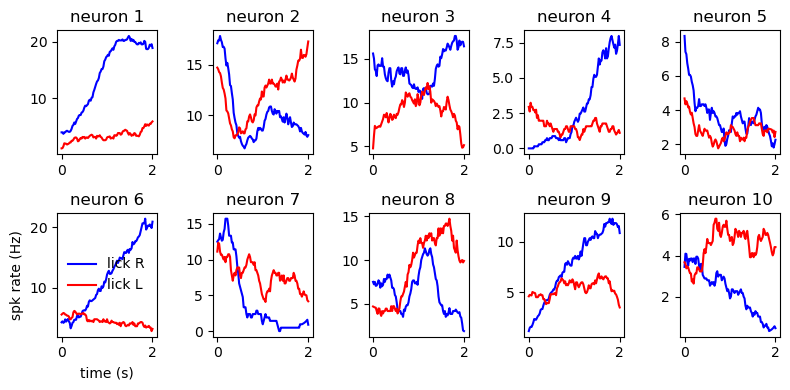

In [7]:
# Plot the activity patterns of ALM Pyramidal neurons
tvec = 0.02 * collect(0:100)
figure(figsize=(8,4))
for ci = 1:10
    subplot(2,5,ci)
    title("neuron $(ci)")
    plot(tvec, rtarg_lickright[ci,:], c="b", label="lick R")
    plot(tvec, rtarg_lickleft[ci,:], c="r", label="lick L")
    if ci == 6
        xlabel("time (s)")
        ylabel("spk rate (Hz)")
        legend(frameon=false, fontsize=10)
    end
end
tight_layout()
PyPlot.display_figs()

### (b) Stimulus to trigger target activity patterns

In [8]:
# Generate stimulus to trigger response.
include("src_spiking_balanced/genStim.jl")

stim = Vector{Array{Float64,2}}()
for lick = 1:2
    stim_val = genStim(p)
    push!(stim, stim_val);
end

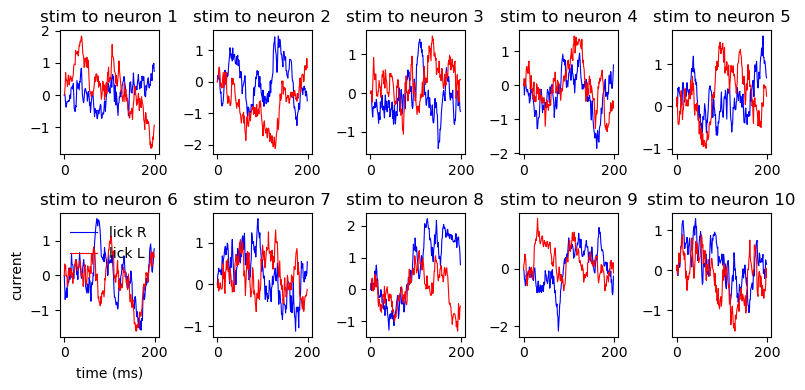

In [9]:
figure(figsize=(8,4))
for ci = 1:10
    subplot(2,5,ci)
    title("stim to neuron $(ci)")
    plot(stim[1][1:10:end,ci], c="b", label="lick R", lw=0.8)
    plot(stim[2][1:10:end,ci], c="r", label="lick L", lw=0.8)
    if ci == 6
        xlabel("time (ms)")
        ylabel("current")
        legend(frameon=false)
    end
end
tight_layout()
PyPlot.display_figs()

### (c) Select a subset of neurons to train

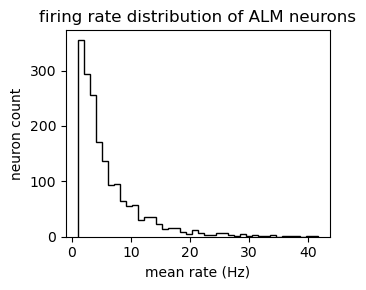

In [10]:
# firing rate distribution
figure(figsize=(3.5,3))
title("firing rate distribution of ALM neurons")
mean_rate = mean(rtarg_lickright,dims=2)[:]
hist(mean_rate, bins=40, histtype="step", color="k")
xlabel("mean rate (Hz)")
ylabel("neuron count")
tight_layout()
PyPlot.display_figs()

Match the mean firing rates of ALM neurons and model neurons

In [11]:
include("src_spiking_balanced/genCellsTrained.jl")
# sample a subset of neurons to be trained
Npyr = size(rtarg_lickleft,1) # Npyr = 1824
Ntrained = Npyr 
rtarg_mean = (rtarg_lickright + rtarg_lickleft)/2;
almOrd, matchedCells = genCellsTrained(p, rtarg_mean, ns0);


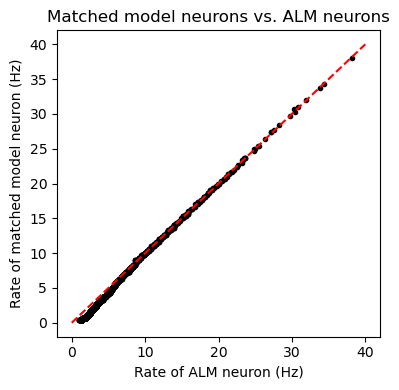

In [12]:
alm_mean_rate = mean(rtarg_mean,dims=2)[almOrd]
model_mean_rate = ns0[matchedCells] / (p.train_time/ 1000)
idline = collect(0:40)
figure(figsize=(4,4))
title("Matched model neurons vs. ALM neurons")
plot(alm_mean_rate, model_mean_rate, c="k", marker="o", ms=3, linestyle="")
plot(idline, idline, c="r", linestyle="--")
xlabel("Rate of ALM neuron (Hz)")
ylabel("Rate of matched model neuron (Hz)")
tight_layout()
PyPlot.display_figs()


### (d) Initialize sparse plastic synapses to train

In [13]:
# Generate plastic connections to be trained
include("src_spiking_balanced/genPlasticWeights.jl")
include("src_spiking_balanced/convertWgtIn2Out.jl")
wpWeightFfwd, wpWeightIn, wpWeightOut, 
wpIndexIn, wpIndexOut, wpIndexConvert, 
ncpIn, ncpOut = genPlasticWeights(p, w0Index, nc0, ns0, matchedCells);


### Initialize plastic feedforward conections to neurons (optional)

In [14]:
# generate feedforward drive
include("src_spiking_balanced/genffwdRate.jl")
# include("src_spiking_balanced/funMovAvg.jl")

ffwdRate_mean = 5.0; # Hz
ffwdRate = Vector{Array{Float64,2}}();
for lick = 1:2
    ffwdRate_val = genffwdRate(p, ffwdRate_mean);
    push!(ffwdRate, ffwdRate_val);
end

## 3 Train a subset of neurons in the balanced network

Train a subset of neurons to follow target activity patterns

In [17]:
#train spatial model
using Statistics
p.nloop=200

include("src_spiking_balanced/lifnet_train.jl")
include("src_spiking_balanced/lifnet_test.jl")
include("src_spiking_balanced/runperformance.jl")

#define path to data network 
dirNetwork = "src_spiking_balanced/data_network/"
mkpath(dirNetwork)

mode = "train"
wpWeightIn, wpWeightOut, wpWeightFfwd = lifnet_train(dirNetwork,p,w0Index,w0Weights,nc0, stim, xtarg,
wpWeightFfwd, wpIndexIn, wpIndexOut, wpIndexConvert, wpWeightIn, wpWeightOut, ncpIn, ncpOut,
almOrd, matchedCells, ffwdRate, mode);


Loop no. 1
elapsed time: 45.015531063079834
Loop no. 2
elapsed time: 42.756792068481445
Loop no. 3
elapsed time: 42.975180864334106
Loop no. 4
elapsed time: 42.59765100479126
Loop no. 5
elapsed time: 42.68785095214844
Loop no. 6
elapsed time: 42.00822114944458
Loop no. 7
elapsed time: 42.8891179561615
Loop no. 8
elapsed time: 42.77061486244202
Loop no. 9
elapsed time: 42.66601085662842
Loop no. 10
elapsed time: 42.516228914260864
Loop no. 11
elapsed time: 43.09380292892456
Loop no. 12
elapsed time: 42.407695055007935
Loop no. 13
elapsed time: 42.09590291976929
Loop no. 14
elapsed time: 42.120553970336914
Loop no. 15
elapsed time: 42.792547941207886
Loop no. 16
elapsed time: 42.83803105354309
Loop no. 17
elapsed time: 41.850727796554565
Loop no. 18
elapsed time: 42.803637981414795
Loop no. 19
elapsed time: 42.78091788291931
Loop no. 20
elapsed time: 46.09311890602112
Loop no. 21
elapsed time: 43.599446058273315
Loop no. 22
elapsed time: 51.24366092681885
Loop no. 23
elapsed time: 47.722

Save the trained network

In [ ]:
include("src_spiking_balanced/save_load_trained_ntwk.jl");
dir_trained_network = "src_spiking_balanced/data_trained_network/"

#--- save a trained network ---#
# save_trained_network(dir_trained_network)

Load and simulate a previously trained network

In [ ]:

#--- load a previously trained network ---#
_p, _w0Index, _w0Weights, _wpWeightIn, _wpWeightOut, _wpWeightFfwd, 
_wpIndexIn, _wpIndexOut, _wpIndexConvert, 
_nc0, _ncpIn, _ncpOut, _xtarg, _stim, 
_almOrd, _matchedCells, _ffwdRate = load_trained_network(dir_trained_network);

#--- simulate a trained network ---#
_xtotal, _, _, _, _, _, 
_, _, _, _, 
_, _, _, _ = lifnet_test("",_p,_w0Index,_w0Weights,_nc0, _stim, _xtarg,
        _wpWeightFfwd, _wpIndexIn, _wpIndexOut, _wpIndexConvert, _wpWeightIn, _wpWeightOut, _ncpIn, _ncpOut,
        _almOrd, _matchedCells, _ffwdRate);


Show training performance

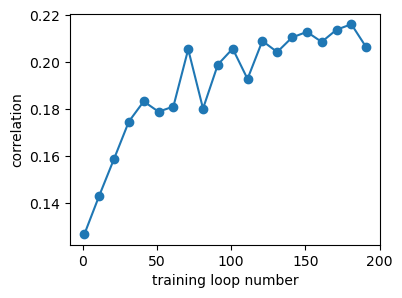

In [107]:
#Check correlation between xtarg and xtotal
loop_numbers = range(1, stop=p.nloop, step=10)
corr_vals=Float64[]

for l in 10:10:p.nloop
    filename = dirNetwork * "_performance_R_loop$(l).txt"
    corr = [parse(Float64, item) for item in readlines(filename)][1]
    push!(corr_vals, corr)
end
figure(figsize=(4,3))
plot(loop_numbers, corr_vals,"-o")
ylabel("correlation")
xlabel("training loop number")
PyPlot.display_figs()

## 4 Show the activity of trained neurons

Show that trained neurons' activity follow the target activity patterns

In [ ]:
iloop=200
xtotal = load(dirNetwork * "xtotal_$(iloop).jld")["xtotal"]
times_trained = load(dirNetwork * "times_$(iloop).jld")["times"]
ns_trained = load(dirNetwork * "ns_$(iloop).jld")["ns"];

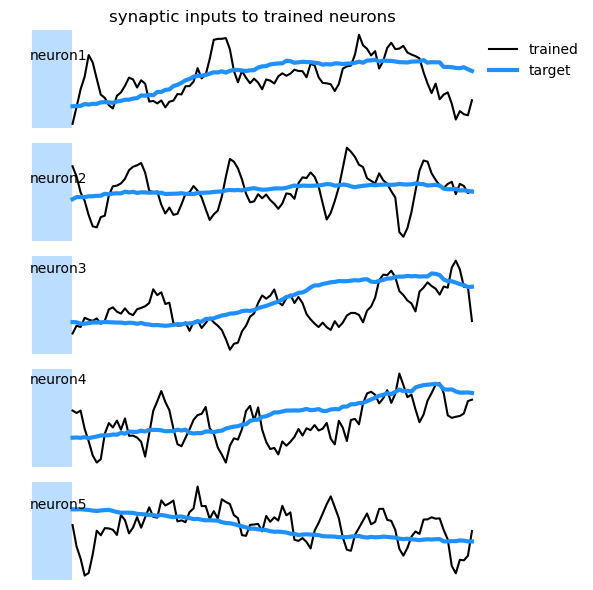

[10010.0, 10210.0, 10410.0, 10610.0, 10810.0, 11010.0, 11210.0, 11410.0, 11610.0, 11810.0, 12010.0, 12210.0, 12410.0, 12610.0, 12810.0, 13010.0, 13210.0, 13410.0, 13610.0, 13810.0, 14010.0, 14210.0, 14410.0, 14610.0, 14810.0, 15010.0, 15210.0, 15410.0, 15610.0, 15810.0, 16010.0, 16210.0, 16410.0, 16610.0, 16810.0, 17010.0, 17210.0, 17410.0, 17610.0, 17810.0, 18010.0, 18210.0, 18410.0, 18610.0, 18810.0, 19010.0, 19210.0, 19410.0, 19610.0, 19810.0, 20010.0, 20210.0, 20410.0, 20610.0, 20810.0, 21010.0, 21210.0, 21410.0, 21610.0, 21810.0, 22010.0, 22210.0, 22410.0, 22610.0, 22810.0, 23010.0, 23210.0, 23410.0, 23610.0, 23810.0, 24010.0, 24210.0, 24410.0, 24610.0, 24810.0, 25010.0, 25210.0, 25410.0, 25610.0, 25810.0, 26010.0, 26210.0, 26410.0, 26610.0, 26810.0, 27010.0, 27210.0, 27410.0, 27610.0, 27810.0, 28010.0, 28210.0, 28410.0, 28610.0, 28810.0, 29010.0, 29210.0, 29410.0, 29610.0, 29810.0]

In [87]:
# compare synaptic activity and its target activity
tvec = collect((p.stim_off+1)/p.dt:p.learn_every/p.dt:p.train_time/p.dt);
ttarg = collect((p.stim_off+1)/p.dt:p.learn_every/p.dt:p.train_time/p.dt); #.+ 2000.0
print(tvec)

figure(figsize=(6,6))
for ci = 1:5
    subplot(5,1,ci)
    # ci_rnd = shuffle(collect(1:Ntrained))[1]
    cell_model = matchedCells[ci]
    cell_alm   = almOrd[ci]
    axvspan(p.stim_on/p.dt, p.stim_off/p.dt, color="dodgerblue", alpha=0.3, ec="None")
    plot(tvec, xtotal[:,cell_model].+p.muemax, c="k", label = "trained")
    plot(ttarg, xtarg[1][2:end,cell_alm], c="dodgerblue", lw=3, label="target")
    annotate("neuron$(ci)", ((p.stim_on/p.dt)-100,maximum(xtarg[1][2:end,cell_alm])), fontsize=10)        
    if ci ==1
        title("synaptic inputs to trained neurons")
        legend(frameon=false, bbox_to_anchor=(1.2, 1.0),loc="upper right")
    end
    axis("off")
end
tight_layout()
PyPlot.display_figs()

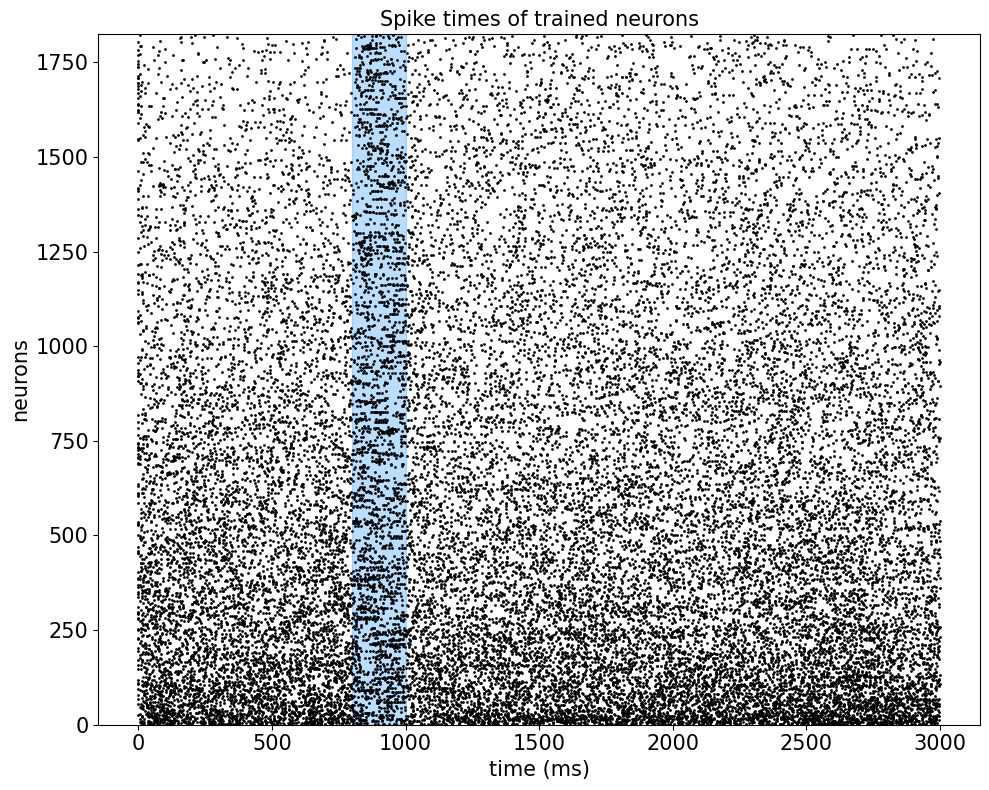

In [ ]:
# Show spike times of a population of neurons
figure(figsize=(10,8))
title("Spike times of trained neurons", fontsize=15)
axvspan(800, 1000, color="dodgerblue", alpha=0.3)
for ci = 1:Ntrained
    cell_model = matchedCells[ci]
    plot(times_trained[cell_model][1:ns_trained[cell_model]], ci*ones(ns_trained[cell_model]), marker=".", ms=4, mec="None", c="k", linestyle="")
end
plt.ylim([0,Ntrained])
xlabel("time (ms)", fontsize=15)
ylabel("neurons", fontsize=15)
xticks(fontsize=15)
yticks(fontsize=15)
tight_layout()
# savefig("figure/spiking_balanced_spkraster.png", dpi=300)
PyPlot.display_figs()

## 2.3 Show the activity of untrained neurons